# **Setup**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import files

# **Load in the data set. (Theres two different methods)**

**Straight from Kaggle.**

In order for this method to work, you **NEED** to download the kaggle api token and add it to your google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

 98% 572M/586M [00:06<00:00, 142MB/s]
100% 586M/586M [00:06<00:00, 96.7MB/s]


In [ ]:
!unzip animals10.zip

# **Local Download (Skip if you did other method)**

Other method if you download directly from kaggle, and add it to your google drive. It will unzip the files and add it to drive.

In [ ]:
import zipfile
zipref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip','r')
zipref.extractall('/tmp')
zipref.close

In [ ]:
!unzip /content/drive/MyDrive/archive.zip

# **Split and create variables for dataset**

In [ ]:
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel", "ragno": "Spider"}

In [ ]:
fpath = "/content/raw-img/"
#Creating Dataframe of images' path
foldernames = os.listdir(fpath)
files, files2, target, target2 = [], [], [], []

for i, folder in enumerate(foldernames):
    filenames = os.listdir(fpath+ folder);
    count = 0
    for file in filenames:
        # elephant has 1446 imges only. To maintain uniformty of counts among different classes, choose only first 1400 images
        #Changed it to 20000 to remove the limit for each class.
        if count < 20000:
            files.append(fpath + folder + "/" + file)
            target.append(translate[folder])
        else:
            files2.append(fpath + folder + "/" + file)
            target2.append(translate[folder])
        count += 1

df = pd.DataFrame({'Filepath':files, 'Target':target})
dft = pd.DataFrame({'Filepath':files2, 'Target':target2})
#split the data into 80/10/10
train, other = train_test_split(df, test_size=0.2, random_state = 0)
valid, test = train_test_split(other, test_size=.5, random_state = 0)


In [ ]:
#data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              rotation_range=30, 
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              samplewise_center = True)

In [ ]:
#Training data
traindata = datagen.flow_from_dataframe(train, 
                                        x_col = 'Filepath', 
                                        y_col = 'Target',
                                        target_size=(224,224),
                                        batch_size=64, 
                                        interpolation = 'lanczos', 
                                        validate_filenames = False)
#Validation Data
validdata = datagen.flow_from_dataframe(valid, 
                                        x_col = 'Filepath', 
                                        y_col = 'Target',
                                        target_size=(224,224),
                                        batch_size=4, 
                                        interpolation = 'lanczos', 
                                        validate_filenames = False)
#Testing Data
testdata = datagen.flow_from_dataframe(test, 
                                        x_col = 'Filepath', 
                                        y_col = 'Target',
                                        target_size=(224,224),
                                        batch_size=4, 
                                        interpolation = 'lanczos', 
                                        validate_filenames = False)

Found 20943 non-validated image filenames belonging to 10 classes.
Found 2618 non-validated image filenames belonging to 10 classes.
Found 2618 non-validated image filenames belonging to 10 classes.


# **Create the Inception Block**

In [ ]:
def Inception(input, filters1, filters2conv1, filters2conv3, filters3conv1, filters3conv5, filters4):
  #First 1x1 covolution layer
  path1 = tf.keras.layers.Conv2D(filters=filters1,kernel_size=(1,1), activation="relu", padding = "same")(input)
  #Second path with 1x1 convolution layer and 3x3 convolution layer
  path2 = tf.keras.layers.Conv2D(filters=filters2conv1, kernel_size=(1,1), activation="relu", padding = "same")(input)
  path2 = tf.keras.layers.Conv2D(filters=filters2conv3, kernel_size=(3,3), activation="relu", padding = "same")(path2)
  #Third path with 1x1 convolution layer and 5x5 convolution layer
  path3 = tf.keras.layers.Conv2D(filters=filters3conv1, kernel_size=(1,1), activation="relu", padding = "same")(input)
  path3 = tf.keras.layers.Conv2D(filters=filters3conv5, kernel_size=(5,5), activation="relu", padding = "same")(path3)
  #Fourth path with 3x3 Pooling and 3x3 convolution layer
  path4 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding = "same")(input)
  path4 = tf.keras.layers.Conv2D(filters=filters1, kernel_size=(1,1), activation="relu", padding = "same")(path4)
  #Output layer
  output = tf.keras.layers.concatenate([path1, path2, path3, path4], axis = -1)

  return output

# **Build the neural network**

In [ ]:
#input shape
inputlayer = tf.keras.layers.Input(shape =(224, 224, 3))
#Convolution 1
conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=2,  activation="relu", padding="valid")(inputlayer)
#Pooling 1
pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2,padding = "same")(conv1)
#Convolution 2
conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=1,  activation="relu", padding="same")(pooling1)
#Convolution 3
conv3 = tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=1, activation="relu", padding="same")(conv2)
#Pooling 2
pooling2 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding = "same")(conv3)
#Inception Block 1
incept1 = Inception(pooling2, 64, 96, 128, 16, 32, 32)
#Inception Block 2
incept2 = Inception(incept1, 128, 128, 192, 32, 96, 64)
#Pooling 3
pooling3 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding = "same")(incept2)
#Inception Block 3
incept3 = Inception(pooling3, 192, 96, 208, 16, 48, 64)

# **First Auxilary Classifier**

In [ ]:
aux1pool = tf.keras.layers.AveragePooling2D(pool_size=(5,5), strides = 3)(incept3)
aux1conv = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding="same", activation="relu")(aux1pool)
aux1flat = tf.keras.layers.Flatten()(aux1conv)
aux1dense1 =  tf.keras.layers.Dense(1024, activation="relu")(aux1flat)
aux1dropout = tf.keras.layers.Dropout(.7)(aux1dense1)
aux1dense2 =  tf.keras.layers.Dense(10, activation="softmax")(aux1dropout)

Continue building the neural network

In [ ]:
#Inception Block 4
incept4 = Inception(incept3, 160, 112, 224, 24, 64, 64)
#inception block 5
incept5 = Inception(incept4, 128, 128, 256, 24, 64, 64)
#Inception block 6
incept6 = Inception(incept5, 112, 144, 288, 32, 64, 64)

# **Second Auxilary Classifier**

In [ ]:
aux2pool = tf.keras.layers.AveragePooling2D(pool_size=(5,5), strides = 3)(incept6)
aux2conv = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding="same", activation="relu")(aux2pool)
aux2flat = tf.keras.layers.Flatten()(aux2conv)
aux2dense1 =  tf.keras.layers.Dense(1024, activation="relu")(aux2flat)
aux2dropout = tf.keras.layers.Dropout(.7)(aux2dense1)
aux2dense2 =  tf.keras.layers.Dense(10, activation="softmax")(aux2dropout)

In [ ]:
#Inception Block 7
incept7 = Inception(incept6, 256, 160, 320, 32, 128, 128)
#Pooling 4
pooling4 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding = "same")(incept7)
#inception block 8
incept8 = Inception(pooling4, 256, 160, 320, 32, 128, 128)
#Inception block 9
incept9 = Inception(incept8, 384, 192, 384, 48, 128, 128)
#Average Pooling
avgpool = tf.keras.layers.GlobalAveragePooling2D()(incept9)
#Dropout
dropout = tf.keras.layers.Dropout(.4)(avgpool)
#output
outputlayer = tf.keras.layers.Dense(10, activation="softmax")(dropout)


# **Model Summary**

In [ ]:
model = tf.keras.Model(inputlayer, [outputlayer, aux1dense2, aux2dense2], name="InceptionV1")
model.summary()

Model: "InceptionV1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']                 
                                                                                        

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# **Train the model**

For accuracy and loss, we only really care about dense_4 loss and dense_4 accuracy as that is our final output, while the other denses' are for the auxiliary classifiers.

Same with val_dense_4 and val_accuracy_4

In [ ]:
history = model.fit(traindata, epochs=20, validation_data=validdata)

Epoch 1/20
328/328 [==============================] - 329s 964ms/step - loss: 6.3965 - dense_4_loss: 2.1588 - dense_1_loss: 2.1024 - dense_3_loss: 2.1352 - dense_4_accuracy: 0.2376 - dense_1_accuracy: 0.2572 - dense_3_accuracy: 0.2450 - val_loss: 5.9059 - val_dense_4_loss: 2.0169 - val_dense_1_loss: 1.8911 - val_dense_3_loss: 1.9979 - val_dense_4_accuracy: 0.2918 - val_dense_1_accuracy: 0.3270 - val_dense_3_accuracy: 0.3029
Epoch 2/20
328/328 [==============================] - 309s 942ms/step - loss: 5.5448 - dense_4_loss: 1.8856 - dense_1_loss: 1.7962 - dense_3_loss: 1.8630 - dense_4_accuracy: 0.3389 - dense_1_accuracy: 0.3680 - dense_3_accuracy: 0.3487 - val_loss: 4.8655 - val_dense_4_loss: 1.6519 - val_dense_1_loss: 1.5839 - val_dense_3_loss: 1.6298 - val_dense_4_accuracy: 0.4316 - val_dense_1_accuracy: 0.4568 - val_dense_3_accuracy: 0.4354
Epoch 3/20
328/328 [==============================] - 312s 950ms/step - loss: 4.6977 - dense_4_loss: 1.5988 - dense_1_loss: 1.5141 - dense_3_los

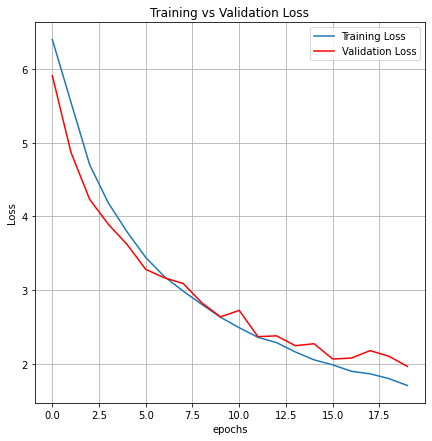

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss", color = "red")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.title("Training vs Validation Loss")
plt.legend()

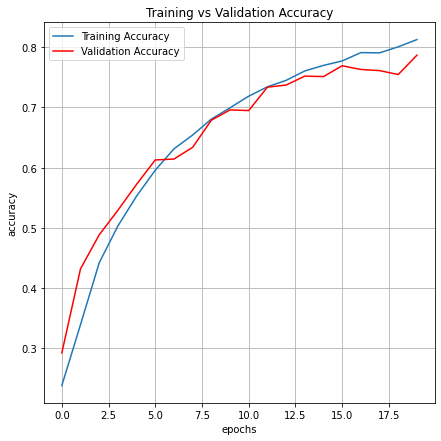

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(history.history["dense_4_accuracy"], label="Training Accuracy")
plt.plot(history.history["val_dense_4_accuracy"], label="Validation Accuracy", color = "red")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.title("Training vs Validation Accuracy")
plt.legend()

In [ ]:
score = model.evaluate(testdata)

655/655 [==============================] - 37s 56ms/step - loss: 1.9083 - dense_4_loss: 0.6361 - dense_1_loss: 0.6408 - dense_3_loss: 0.6313 - dense_4_accuracy: 0.7895 - dense_1_accuracy: 0.7895 - dense_3_accuracy: 0.7880
